# Build a transformer based classification model to verify the veracity of claims.

To build this model we will be using PUBHEALTH a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated veracity label (true, false, unproven, mixture).

In [1]:
# Checking if the device has GPU 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
# performing few computation using to check the system picks GPU to perform it
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

def cpu():
    with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
    with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.978197908999988
GPU (s):
0.05087098000001333
GPU speedup over CPU: 38x


#Exploring the data and performing minor data manipulations
Exploring the data and performing minor manipulation and making to ready to fit and perform different experiments.

Installing the necessary libraries and packeges need to build the model and import the dataset which is available along with huggingfaces default datasets.

Libraries needed
1. pytorch
2. transformers
3. pandas
4. sklearn
5. matplotlib

In [4]:
# Pip install all the packages
!pip3 install numpy torch sklearn datasets
!pip install transformers~=2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.4 MB/s 
     |████████████████████████████████| 140 kB 53.3 MB/s 
     |████████████████████████████████| 212 kB 52.0 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 127 kB 68.2 MB/s 
     |████████████████████████████████| 144 kB 56.2 MB/s 
     |████████████████████████████████| 271 kB 63.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's depe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 674 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 64.0 MB/s 
     |████████████████████████████████| 5.6 MB 27.1 MB/s 
     |████████████████████████████████| 880 kB 15.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5bb4fbfe88dda450d8a407a97a9741a7a964db619ff5aaa752095b48f3cff58b
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [5]:
# Import the libraries
import torch
import pandas as pd
from tqdm.notebook import tqdm
from datasets import list_datasets
datasets_list = list_datasets()
print(datasets_list)

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews', 'allocine', 'alt', 'amazon_polarity', 'amazon_reviews_multi', 'amazon_us_reviews', 'ambig_qa', 'americas_nli', 'ami', 'amttl', 'anli', 'app_reviews', 'aqua_rat', 'aquamuse', 'ar_cov19', 'ar_res_reviews', 'ar_sarcasm', 'arabic_billion_words', 'arabic_pos_dialect', 'arabic_speech_corpus', 'arcd', 'arsentd_lev', 'art', 'arxiv_dataset', 'ascent_kb', 'aslg_pc12', 'asnq', 'asset', 'assin', 'assin2', 'atomic', 'autshumato', 'babi_qa', 'banking77', 'bbaw_egyptian', 'bbc_hindi_nli', 'bc2gm_corpus', 'beans', 'best2009', 'bianet', 'bible_para', 'big_patent', 'billsum', 'bing_coronavirus_query_set', 'biomrc', 'biosses', 'blbooks', 'blbooksgenre', 'blended_skill_talk', 'blimp', 'blog_authorship_corpus', 'bn_hate_speech', 'bnl_newspapers', 'bookcorpus', 'bookcorpusopen', 'boolq', 'bprec', 'break_data', 'brwac', 'bsd_ja_en', 'bswac'

In [6]:
# Importing the dataset
from datasets import load_dataset
data = load_dataset('health_fact', split='train')
print(data.description)

Using custom data configuration default


Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.
PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of
public health claims. Each instance in the PUBHEALTH dataset has an associated
veracity label (true, false, unproven, mixture). Furthermore each instance in the
dataset has an explanation text field. The explanation is a justification for which
the claim has been assigned a particular veracity label.

The dataset was created to explore fact-checking of difficult to verify claims i.e.,
those which require expertise from outside of the journalistics domain, in this case
biomedical and public health expertise.

It was also created in response to the lack of fact-checking datasets which provide
gold standard natural language explanations for verdicts/labels.

NOTE: There are missing labels in the datase

In [7]:
# Taking a look at the data
print("Columns {}".format(data.num_columns))
print("Rows {}".format(data.num_rows))
print("Columns names {}".format(data.column_names))

Columns 9
Rows 9832
Columns names ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects']


In [8]:
# creating a new column by merging the claim and the explaination columns
data = data.to_pandas()
data['data'] = data['claim'].map(str) + ' ' + data['explanation'].map(str)
data

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,data
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,","""The money the Clinton Foundation took from fr..."
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",Annual Mammograms May Have More False-Positive...
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",SBRT Offers Prostate Cancer Patients High Canc...
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health","Study: Vaccine for Breast, Ovarian Cancer Has ..."
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,Some appendicitis cases may not require ’emerg...
...,...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,3,"Politics Medical, COVID-19",The Sturgis motorcycle rally in 2020 resulted ...
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,2,Health News,AstraZeneca's infant respiratory drug prioriti...
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,2,Health News,Testicular cancer deaths double with after 40 ...
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,0,Medical,The FDA published “conclusive proof” that the...


In [9]:
# dropping the columns which we will not be using and the missing labels which was labeled as -1
print(data['label'].value_counts())
data = data[['data','label']]
data = data[data['label']!=-1]
data

 2    5078
 0    3001
 1    1434
 3     291
-1      28
Name: label, dtype: int64


,data,label
0,"""The money the Clinton Foundation took from fr...",0
1,Annual Mammograms May Have More False-Positive...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,1
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",2
4,Some appendicitis cases may not require ’emerg...,2
...,...,...
9827,The Sturgis motorcycle rally in 2020 resulted ...,3
9828,AstraZeneca's infant respiratory drug prioriti...,2
9829,Testicular cancer deaths double with after 40 ...,2
9830,The FDA published “conclusive proof” that the...,0


In [10]:
# Get the lists of sentences and their labels.
sentences = data.data.values
labels = data.label.values


# Tokenize Dataset

The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps.

Before encoding, finding the maximum sentence length for padding / truncating.

In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  "The money the Clinton Foundation took from from foreign governments while Hillary Clinton was secretary of state ""is clearly illegal. … The Constitution says you can’t take this stuff." "Gingrich said the Clinton Foundation ""took money from from foreign governments while (Hillary Clinton) was secretary of state. It is clearly illegal. … The Constitution says you can’t take this stuff."" A clause in the Constitution does prohibit U.S. officials such as former Secretary of State Hillary Clinton from receiving gifts, or emoluments, from foreign governments. But the gifts in this case were donations from foreign governments that went to the Clinton Foundation, not Hillary Clinton. She was not part of the foundation her husband founded while she was secretary of state. Does that violate the Constitution? Some libertarian-minded constitutional law experts say it very well could. Others are skeptical. What’s clear is there is room for ambiguity, and the donations are anything b

In [13]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Max sentence length:  920


In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:  "The money the Clinton Foundation took from from foreign governments while Hillary Clinton was secretary of state ""is clearly illegal. … The Constitution says you can’t take this stuff." "Gingrich said the Clinton Foundation ""took money from from foreign governments while (Hillary Clinton) was secretary of state. It is clearly illegal. … The Constitution says you can’t take this stuff."" A clause in the Constitution does prohibit U.S. officials such as former Secretary of State Hillary Clinton from receiving gifts, or emoluments, from foreign governments. But the gifts in this case were donations from foreign governments that went to the Clinton Foundation, not Hillary Clinton. She was not part of the foundation her husband founded while she was secretary of state. Does that violate the Constitution? Some libertarian-minded constitutional law experts say it very well could. Others are skeptical. What’s clear is there is room for ambiguity, and the donations are anything bu

# Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,823 training samples
  981 validation samples


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--4 for multiclass classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Model parameters


1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.







In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#  Optimizer & Learning Rate Scheduler

Now the model has been loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, I went through the following paper from BERT authors (from Appendix A.3 of the BERT paper):

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

Then I chose
Batch size: 32
Learning rate: 2e-5
Epochs: 4 



In [19]:
# Note: AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [20]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. after researching and going through blogs the BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Training the model

Training the model and few helper function to evaluate the model

In [21]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
import random
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    276.    Elapsed: 0:00:15.
  Batch    80  of    276.    Elapsed: 0:00:31.
  Batch   120  of    276.    Elapsed: 0:00:46.
  Batch   160  of    276.    Elapsed: 0:01:01.
  Batch   200  of    276.    Elapsed: 0:01:16.
  Batch   240  of    276.    Elapsed: 0:01:31.

  Average training loss: 0.81
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.71
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    276.    Elapsed: 0:00:15.
  Batch    80  of    276.    Elapsed: 0:00:30.
  Batch   120  of    276.    Elapsed: 0:00:46.
  Batch   160  of    276.    Elapsed: 0:01:01.
  Batch   200  of    276.    Elapsed: 0:01:16.
  Batch   240  of    276.    Elapsed: 0:01:31.

  Average training loss: 0.63
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.68
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
 

# Evaluating the models performance

In [24]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.81,0.71,0.70,0:01:45,0:00:04
2,0.63,0.68,0.71,0:01:45,0:00:04
3,0.50,0.70,0.73,0:01:45,0:00:04
4,0.40,0.74,0.72,0:01:45,0:00:04


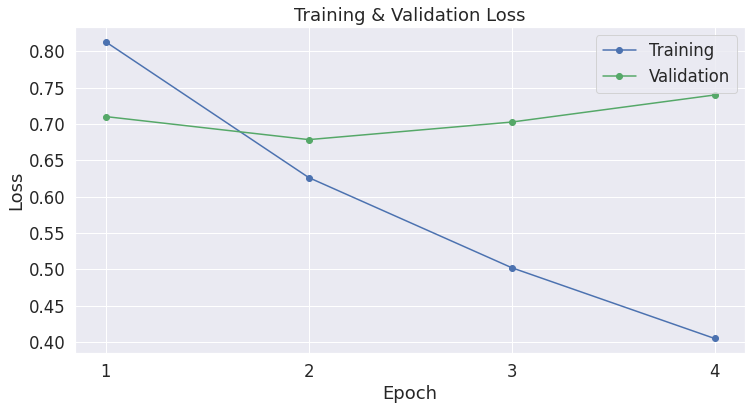

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance On Test Set

In [26]:
# Importing the dataset
from datasets import load_dataset
test_data = load_dataset('health_fact', split='test')
print(test_data.description)

Using custom data configuration default
Reusing dataset health_fact (/root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of
public health claims. Each instance in the PUBHEALTH dataset has an associated
veracity label (true, false, unproven, mixture). Furthermore each instance in the
dataset has an explanation text field. The explanation is a justification for which
the claim has been assigned a particular veracity label.

The dataset was created to explore fact-checking of difficult to verify claims i.e.,
those which require expertise from outside of the journalistics domain, in this case
biomedical and public health expertise.

It was also created in response to the lack of fact-checking datasets which provide
gold standard natural language explanations for verdicts/labels.

NOTE: There are missing labels in the dataset and we have replaced them with -1.



In [27]:
# Taking a look at the data
print("Columns {}".format(test_data.num_columns))
print("Rows {}".format(test_data.num_rows))
print("Columns names {}".format(test_data.column_names))

Columns 9
Rows 1235
Columns names ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects']


In [29]:
# creating a new column by merging the claim and the explaination columns
test_data = test_data.to_pandas()
test_data['data'] = test_data['claim'].map(str) + ' ' + test_data['explanation'].map(str)
test_data

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,data
0,33456,A mother revealed to her child in a letter aft...,"November 6, 2011",The one-eyed mother story expounds upon two mo...,David Mikkelson,"In April 2005, we spotted a tearjerker on the ...",,0,Glurge Gallery,A mother revealed to her child in a letter aft...
1,2542,Study says too many Americans still drink too ...,"February 25, 2013","On any given day in the United States, 18 perc...",,That means the great majority of Americans sta...,http://bit.ly/X1NVtW,2,Health News,Study says too many Americans still drink too ...
2,26678,Viral image Says 80% of novel coronavirus case...,"March 13, 2020",The website Information is Beautiful published...,Paul Specht,"Amid the spread of the novel coronavirus, many...",https://www.facebook.com/informationisbeautifu...,2,"Facebook Fact-checks, Coronavirus, Viral image,",Viral image Says 80% of novel coronavirus case...
3,40705,An email says that 9-year old Craig Shergold o...,"March 16, 2015",Send greeting or business cards to cancer vict...,Rich Buhler & Staff,Craig Shergold is real and in 1989...,https://www.reddit.com/submit?url=https%3A%2F%...,0,"Inspirational, Pleas",An email says that 9-year old Craig Shergold o...
4,35718,"Employees at a Five Guys restaurant in Daphne,...","July 15, 2020","What's undetermined: As of this writing, Five ...",Dan MacGuill,"In July 2020, amid a new wave of nationwide pr...",,3,Law Enforcement,"Employees at a Five Guys restaurant in Daphne,..."
...,...,...,...,...,...,...,...,...,...,...
1230,3295,Christmas miracle for Florida dog whose heart ...,,A Florida man was hoping for a Christmas mirac...,Associated Press,The heart of Gerald Ford’s 1-year-old French b...,https://www.gainesville.com/news/20200102/holi...,2,"Animals, Health, Florida, General News, Gaines...",Christmas miracle for Florida dog whose heart ...
1231,6904,Another dolphin dies at Arizona aquatic facility.,,A fourth dolphin has died at a Phoenix-area aq...,,A statement from Dolphinaris Arizona in Scotts...,,2,"Arizona, Animals, Phoenix, Health, Dolphins",Another dolphin dies at Arizona aquatic facili...
1232,13874,"What the facts say"" is ... ""the best scenario ...","July 17, 2016","Priebus said, ""What the facts say"" is ... ""the...",Lauren Carroll,Republican National Committee chairman Reince ...,https://www.nytimes.com/2016/07/13/us/politics...,0,"National, Children, Race and Ethnicity, Reince...","What the facts say"" is ... ""the best scenario ..."
1233,2847,FDA advisory panel rejects J&J drug for acute ...,"January 16, 2014",Johnson & Johnson’s anticoagulant Xarelto shou...,,"The panel voted 10 to 0, with one abstention, ...",,2,Health News,FDA advisory panel rejects J&J drug for acute ...


In [30]:
# dropping the columns which we will not be using and the missing labels which was labeled as -1
print(test_data['label'].value_counts())
test_data = test_data[['data','label']]
test_data = test_data[test_data['label']!=-1]
test_data

 2    599
 0    388
 1    201
 3     45
-1      2
Name: label, dtype: int64


,data,label
0,A mother revealed to her child in a letter aft...,0
1,Study says too many Americans still drink too ...,2
2,Viral image Says 80% of novel coronavirus case...,2
3,An email says that 9-year old Craig Shergold o...,0
4,"Employees at a Five Guys restaurant in Daphne,...",3
...,...,...
1230,Christmas miracle for Florida dog whose heart ...,2
1231,Another dolphin dies at Arizona aquatic facili...,2
1232,"What the facts say"" is ... ""the best scenario ...",0
1233,FDA advisory panel rejects J&J drug for acute ...,2


In [31]:
import pandas as pd

# Create sentence and label lists
sentences = test_data.data.values
labels = test_data.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,233 test sentences...
    DONE.


In [33]:
from sklearn.metrics import matthews_corrcoef

predicted = []

# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    predicted.append(pred_labels_i)


In [41]:
pred = []
for i in predicted:
    for j in i:
    pred.append(j)

In [42]:
actual = []
for i in true_labels:
    for j in i:
    actual.append(j)

Confusion Matrix


Accuracy: 0.69


Classification Report

              precision    recall  f1-score   support

        True       0.61      0.72      0.66       388
       False       0.45      0.39      0.42       201
    Unproven       0.82      0.82      0.82       599
     Mixture       1.00      0.07      0.12        45

    accuracy                           0.69      1233
   macro avg       0.72      0.50      0.51      1233
weighted avg       0.70      0.69      0.68      1233





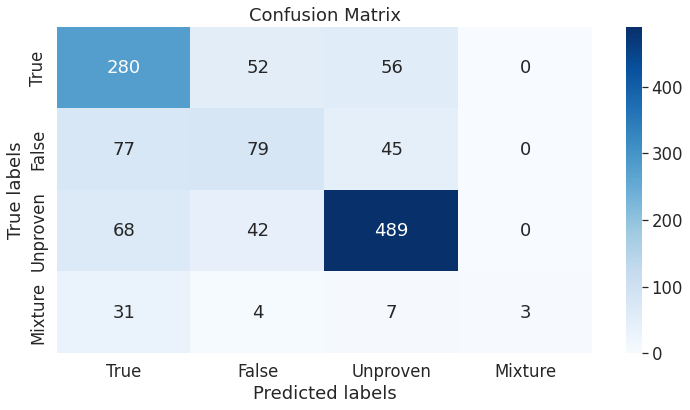

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

target_names=['True', 'False', 'Unproven','Mixture']

confusion = confusion_matrix(actual, pred)
print('Confusion Matrix\n')
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt="d",cmap='Blues',ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(actual, pred)))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(actual, pred, target_names=target_names))
print('\n')